# Development of continuous basis functions derived from BSS-ANOVA kernel for practical use in Pyomo

## Abstract

The Karhunen-Loève decomposition of the BSS-ANOVA kernel, $\kappa$, depends only on the kernel's core, $\kappa_1(x, x')$, which may be constructed with any finite linearly-spaced resolution of $x\ \exist\ [0, 1]$. Eigendecomposing $\kappa_1$ with resolution $500 \times 500$ produces the BSS-ANOVA "Cubic Splines" ($CS$) basis functions $\phi_{i, CS}$, used by default in FoKL, by fitting cubic splines to the eigenvectors scaled by the square root of the corresponding eigenvalues.

Since each $\phi_{i, CS}$ contains $499$ piecewise equations, it is not practical to use in Pyomo. Instead, Bernoulli polynomials ($\mathcal{B}_i$) may be used as an approximate substitute since they are continuous and similarly increase in order. For $\mathcal{B}_i$ to mimic $\phi_{i, CS}$, while maintaining the scaling derived from $\kappa_1$, the following method was developed to arrive at a new set of continuous basis functions, $\phi_{i, \mathcal{B}}$, for use in Pyomo.

## Method

1. $\ \overline{\mathcal{B}_i}\ \Longleftarrow$ [Gram-Schmidt orthogonalization and normalization of Bernoulli polynomials](#gram-schmidt-orthogonalization-and-normalization-of-bernoulli-polynomials)
1. $\frac{\lambda_i}{\lambda_{i-1}} \Longleftarrow$ [Asymptotic ratios of eigenvalues approaching infinite resolution of BSS-ANOVA kernel's core](#asymptotic-ratios-of-eigenvalues-approaching-infinite-resolution-of-bss-anova-kernels-core)
1. $\phi_{i, \mathcal{B}} \Longleftarrow$ [Scaling to minimize total error between basis function sets](#3-scaling-to-minimize-total-error-between-basis-function-sets)

Mathematically, that is

$
\begin{cases}
\overline{\mathcal{B}_i} \equiv \text{Gram-Schmidt orthogonalization and normalization of } \mathcal{B}_i \text{ on } [0, 1] \text{ domain}
\\
\frac{\lambda_i}{\lambda_{i-1}} \equiv \text{asymptotic ratio of } \kappa_1 \text{ eigenvalues approaching } \infty \times \infty \text{ resolution}
\end{cases}
$

$
\implies \phi_{i, \mathcal{B}} \equiv
\sqrt{\lambda_i} \cdot \overline{\mathcal{B}_i} \text{ where } \lambda_i \text{ for } i \gt 1 \text{ obeys } \frac{\lambda_i}{\lambda_{i-1}} \text{ with } \lambda_1 \text{ selected to minimize total error between all } \phi_{i, \mathcal{B}} \text{ and } \phi_{i, CS} \text{, i.e., to minimize } \sum_{i=1}^{n} \int_0^1{|\phi_{i, \mathcal{B}}(x) - \phi_{i, CS}(x)|}dx
$

## Gram-Schmidt orthogonalization and normalization of Bernoulli polynomials

Implemented in MATLAB ([*gram_schmidt_orthogonalization.m*](/docs/_dev/basis_functions/bernoulli_polynomials/gram_schmidt_orthogonalization.m)), the results were verified with eq. (13-21) of [Singh [1]](https://arxiv.org/pdf/2007.10814). The [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) is as follows.

---
```matlab
n = 200; % highest order of Bernoulli polynomial (Bn)
rows = 4; % rows in plot
cols = 6; % columns in plot

% --------------------------------------------------------------------------------------------
% Gram-Schmidt:

syms x real
n = n + 1;
b = cell(n, 1); % Bn
b{1} = bernoulli(0, x);
u = b; % orthogonal and normalized Bn
c = u; % coefficients (i.e., phis) where column corresponds to x^(col-1)
phis = zeros(n, n); % coefficients as matrix (not cell)
cap = false; % true when a coefficient is +/-Inf

for i = 2:n % (i-1)th Bn
    b{i} = bernoulli(i-1, x);
    u{i} = b{i} - int(b{i}, [0,1]); % subtract u0 projection
    for j = 2:i-1 % subtract (j-1)th u projection
        u{i} = u{i} - int(b{i}*u{j}, [0,1]) / int(u{j}*u{j}, [0,1]) * u{j};
    end
    u{i} = simplify(u{i} / sqrt(int(u{i}*u{i}, [0,1]))); % normalize

    c{i} = coeffs(u{i});
    for j = 1:i
        phis(i,j) = c{i}(j);
        if abs(phis(i,j)) == Inf
            cap = true;
            n = i-1; % previous order is max without +/-Inf
            break
        end
    end

    if cap
        break
    end
  
end

writematrix(phis(2:n, 1:n), 'orthogonal_Bn_normalized.txt') % note '1:n' should be same as ':'

% --------------------------------------------------------------------------------------------
% Plot:

f = figure();
i = 0;
for row = 1:rows
    for col = 1:cols
        i = i + 1;
        subplot(rows, cols, i)
        fplot(u{i+1}, [0, 1])
    end
end

saveas(f, 'orthogonal_Bn_normalized__fplot.png')
```
---

$\overline{\mathcal{B}_i} \equiv \sum_{k=0}^i (c_k \cdot x^k)$ for $i\ \exist\ [1, 200]$ is now defined by the coefficients, $c_k$, saved in *orthogonal_Bn_normalized.txt* as follows.

|  | $x^0$ | $x^1$ | $x^2$ | $x^3$ | $\dots$ | $x^{200}$ |
|---|---|---|---|---|---|---|
| $\mathcal{B}_1$ | -1.73205080756888 | 3.46410161513775 | 0 | 0 | $\dots$ | 0 |
| $\mathcal{B}_2$ | 2.23606797749979 | -13.4164078649987 | 13.4164078649987 | 0 | $\dots$ | 0 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\ddots$ | $\vdots$ |
| $\mathcal{B}_{200}$ | 20.0249843945008 | -805004.372658932 | 8089891443.03593 | -36129455184598.5 | $\dots$ | 2.06162220858651e+120 |

However, when plotting, it was found that $\overline{\mathcal{B}_{20}}$ was the highest order without significant rounding error as $x \rightarrow 1$. For this reason, $\phi_{i, \mathcal{B}}$ will be limited to $i=20$.

In future development, some additional higher orders could be used since $\overline{\mathcal{B}_i}$ for $x \le 0.5$ appears to experience less rounding error and the polynomials are symmetric about $x=0.5$; that is,

$\overline{\mathcal{B}_i}(x) = \begin{cases} -\overline{\mathcal{B}_i}(1-x),\ i \text{ is odd} \\ +\overline{\mathcal{B}_i}(1-x),\ i \text{ is even} \end{cases}\ ,\ x \gt 0.5,\ i \gt 20$.

The results of plotting up to $i=24$ are as follows.

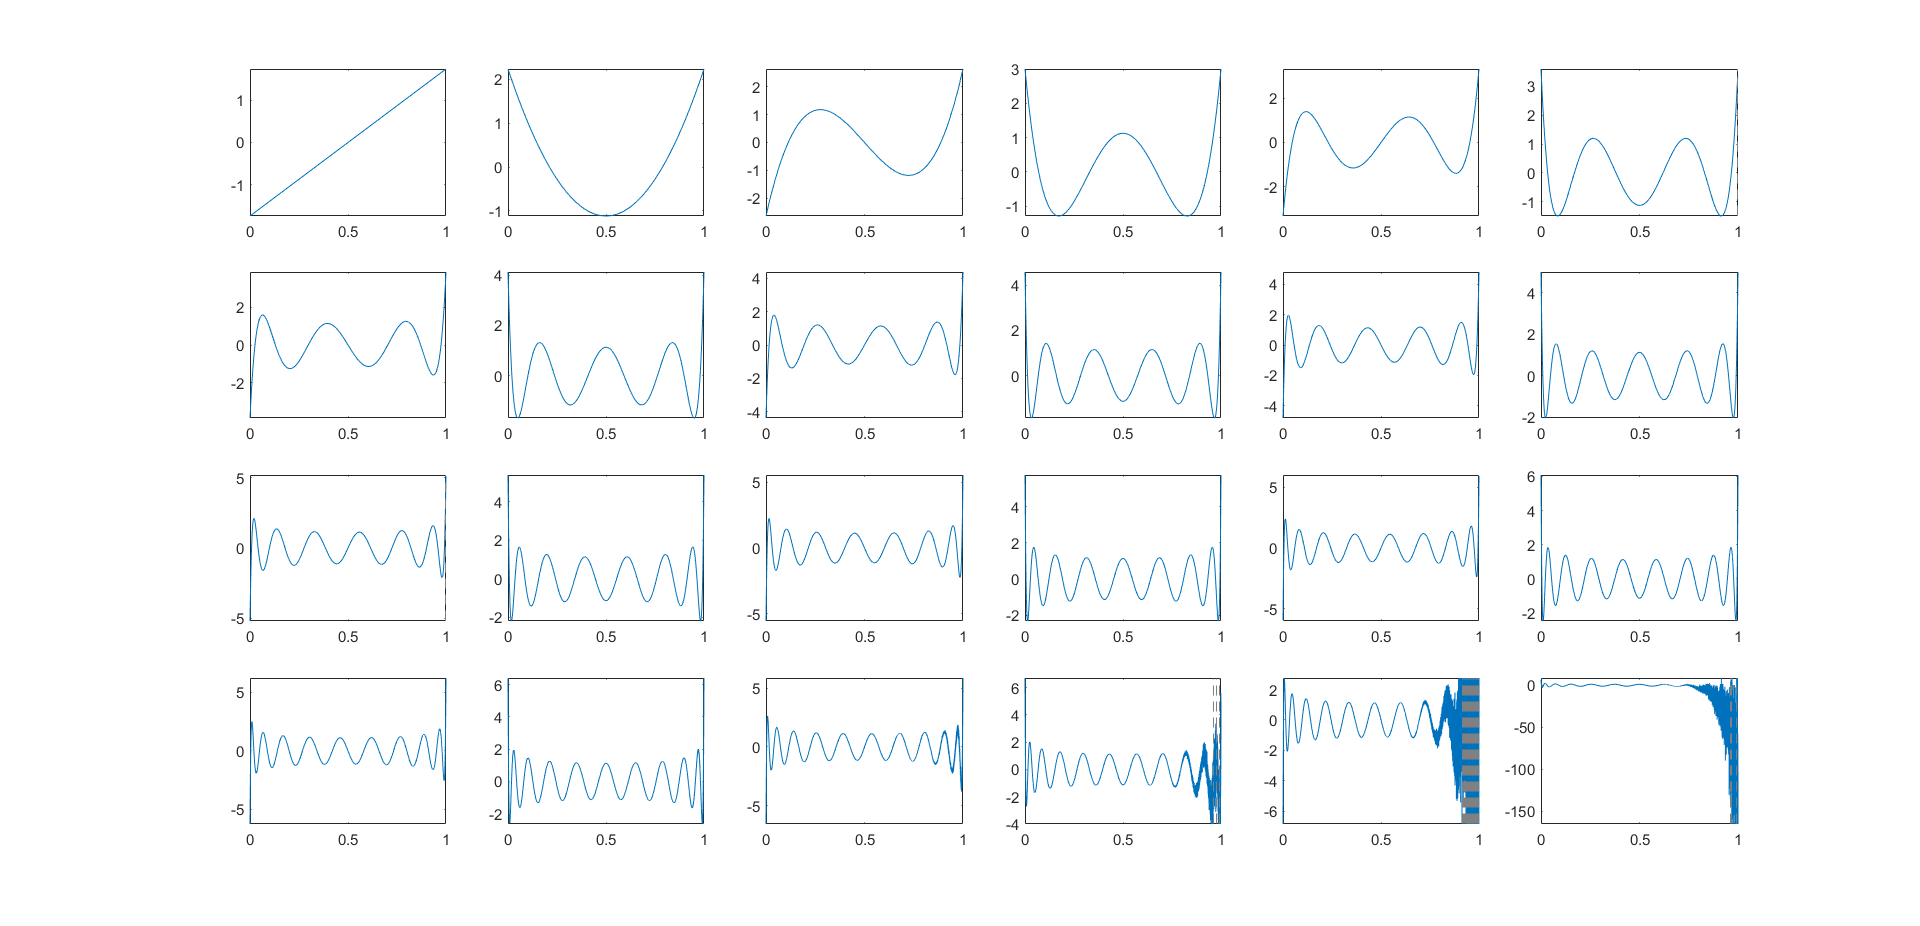

## Asymptotic ratios of eigenvalues approaching infinite resolution of BSS-ANOVA kernel's core

Find asymptotes (of ratios $\frac{\lambda_2}{\lambda_1}, \frac{\lambda_3}{\lambda_2}, \dots, \frac{\lambda_{20}}{\lambda_{19}}$) from *BSS-ANOVA_eigenvalues_for_20x20_thru_2000x2000.txt* generated by [*BSS-ANOVA_eigendecomposition.ipynb*](/docs/_dev/basis_functions/bernoulli_polynomials/BSS-ANOVA_eigendecomposition.ipynb), which only saved up to $\lambda_{20}$ because of the significant rounding error in $\overline{\mathcal{B}_i}$ beyond this.

In [1]:
import numpy as np
from scipy.optimize import curve_fit


def model(x, c0, c1):
    return c0 + c1 / x


# read txt/csv files
data = np.loadtxt('BSS-ANOVA_eigenvalues_for_20x20_thru_2000x2000.txt')
data = data[5::, :]  # ignore some initial data because worsens asymptote fit
res = data[:, 0]
eigval = data[:, 1::]

# define ratios
n, m = eigval.shape
eigratio = np.zeros([n, m - 1])
popt = np.zeros([m - 1, 2])  # (m - 1) x [c0, c1], i.e., eigenvalue ratios by curve fit parameters
eigratio_model = np.zeros_like(eigratio)
for j in range(m - 1):
    eigratio[:, j] = eigval[:, j + 1] / eigval[:, j]

    # fit c0+c1/x, where c0 is asymptote
    popt[j, :], _ = curve_fit(model, res, eigratio[:, j])  # [c0, c1]
    eigratio_model[:, j] = model(res, *popt[j, :])  # fitted curve for visual plot confirmation

Confirm curve fit with plots.

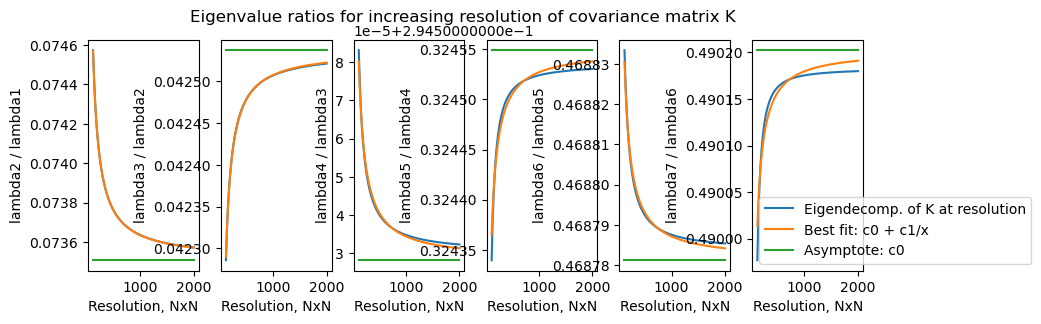

In [2]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 6, figsize=(10, 3))
for j in range(6):
    axs[j].plot(res, eigratio[:, j])  # data
    axs[j].plot(res, eigratio_model[:, j])  # model
    axs[j].plot([res[0], res[-1]], [popt[j, 0], popt[j, 0]])  # asymptote

    axs[j].set_ylabel(f'lambda{j + 2} / lambda{j + 1}')
    axs[j].set_xlabel('Resolution, NxN')

fig.suptitle('Eigenvalue ratios for increasing resolution of covariance matrix K')
plt.legend(['Eigendecomp. of K at resolution', 'Best fit: c0 + c1/x', 'Asymptote: c0'])

## Scaling to minimize total error between basis function sets

Optimize $\sqrt{\lambda_1}$ to minimize error between scaled orthogonal, normalized Bernoulli polynomials ($\phi_{i, \mathcal{B}}$) and BSS-ANOVA basis functions ($\phi_{i, CS}$). Note $\lambda_n = f(\lambda_1)$ according to eigenvalue ratios. 

**ALSO NOTE** $\overline{\mathcal{B}_i}$ flips pos./neg. signs to align with corresponding $\phi_{i, CS}$, which maybe makes $\phi_{i, \mathcal{B}}$ no longer orthogonal, but is likely no problem for $\beta$ (inside FoKL) to flip signs. This is done so the same $\beta$ may be used across the basis function sets, hopefully so the same FoKL model may be used for either basis functions and avoid requiring a re-training.

Formulating more formally,

- $\frac{\lambda_2}{\lambda_1},\ \frac{\lambda_3}{\lambda_2},\ \dots,\ \frac{\lambda_n}{\lambda_{n-1}} \text{ from asymptotes}$
- $h_i \equiv \sqrt{\lambda_i}$
- $h_1 \implies h_2 = \sqrt{h_1^2 (\frac{\lambda_2}{\lambda_1})},\ h_3 = \sqrt{h_2^2 (\frac{\lambda_3}{\lambda_2})},\ \dots,\ h_n = \sqrt{h_{n-1}^2 (\frac{\lambda_n}{\lambda_{n-1}})}$
- $\overline{\mathcal{B}_i} \equiv \text{orthogonal, normalized } i^{th} \text{ Bernoulli polynomial}$
- $\phi_{i, \mathcal{B}} = h_i \cdot \overline{\mathcal{B}_i} \equiv \text{scaled } \overline{\mathcal{B}_i} \text{, which form new basis functions}$
- $\text{Objective: } h_1 \text{ to minimize } \sum_{i=1}^{n} \int_0^1{|\phi_{i, \mathcal{B}}(x) - \phi_{i, CS}(x)|}dx$

In [3]:
from scipy.optimize import minimize
from FoKL import FoKLRoutines


bn = np.loadtxt('orthogonal_Bn_normalized.txt', delimiter=',')  # load orthogonal, normalized Bernoulli polynomials
bn = bn[:20, :21]  # only retain first 20 polynomials (20 polynomials x 21 coefficients)

x = np.linspace(0, 1, 1000)

fokl = FoKLRoutines.FoKL()
fokl.clean(x)

y_bss = []
for i in range(bn.shape[0]):
    y_bss.append(fokl.evaluate(betas=[0, 1], mtx=[i + 1]))

# -------------------

def obective(h1, x, bn, c0, y_bss):

    h = np.zeros(bn.shape[0])  # sqrt(eigval) where eigval is optimal solution for Bn to mimic BSS-ANOVA, preserving eigratio

    h[0] = h1  # optimize h[0] only ... which is sqrt(eig1) of which all else is derived
    for i in range(1, bn.shape[0]):
        h[i] = np.sqrt(h[i - 1] ** 2 * c0[i - 1])

    b_in = []
    y_bn = []
    y_diff = 0
    for i in range(bn.shape[0]):
        b_in.append(bn[i, :(i + 2)] * h[i])
        y_bn.append(sum(b_in[i][k] * x ** k for k in range(len(b_in[i]))))  # basis function

        # CHECK IF SIGN FLIP NEEDED
        if y_bn[i][0] == 0 or y_bss[i][0] == 0:
            print(f'WARNING, check manually for sign flip of {i}.')
        elif np.sign(y_bn[i][0]) != np.sign(y_bss[i][0]):
            b_in[i] = -b_in[i]  # flip sign of Bn
            y_bn[i] = -y_bn[i]
            # print(f'Flipped {i}.')
        
        y_diff += sum(np.abs(y_bss[i] - y_bn[i]))

    return y_diff

c0 = popt[:, 0]
obj = minimize(obective, 0.3, args=tuple([x, bn, c0, y_bss]))

# Save results:

h = np.zeros(bn.shape[0])
h[0] = obj.x[0]  # optimal solution for h1
for i in range(1, bn.shape[0]):
    h[i] = np.sqrt(h[i - 1] ** 2 * c0[i - 1])
b_in = []  # scaled orthogonal Bn
for i in range(bn.shape[0]):
    b_in.append(bn[i, :(i + 2)] * h[i])

    # CHECK IF SIGN FLIP NEEDED
    y_bn = sum(b_in[i][k] * x[0] ** k for k in range(len(b_in[i])))  # FIRST VALUE ONLY of basis function
    if y_bn == 0 or y_bss[i][0] == 0:
        print(f'WARNING, check manually for sign flip of {i}.')
    elif np.sign(y_bn) != np.sign(y_bss[i][0]):
        b_in[i] = -b_in[i]  # flip sign of Bn
        print(f'Flipped {i}')

/home/jacobpatrick/.local/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:727: UserWarning: Assuming 'mtx' represents a single model. If meant to represent several models, then explicitly enter a 2D numpy array where rows correspond to models.
  warnings.warn("Assuming 'mtx' represents a single model. If meant to represent several models, then "


Flipped 4
Flipped 5
Flipped 6
Flipped 7
Flipped 8
Flipped 9
Flipped 10
Flipped 11
Flipped 12
Flipped 14
Flipped 15


With $\sqrt{\lambda_1}$ optimized to minimize error, and some polynomials flipped pos./neg., the polynomials are now thought to be scaled as best they can be to preserve $\beta$.

Checking results with plots ($\phi_{i, CS}$ on top, $\phi_{i, \mathcal{B}}$ on bottom).

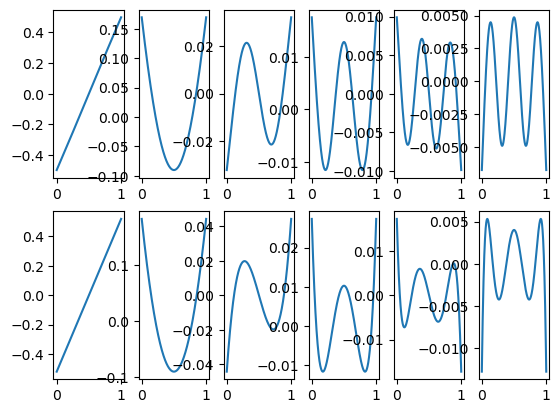

In [4]:
fig, axs = plt.subplots(2, 6)
for j in range(6):
    axs[0, j].plot(x, y_bss[j])  # BSS-ANOVA
    axs[1, j].plot(x, sum(b_in[j][k] * x ** k for k in range(len(b_in[j]))))  # scaled Bn

Repeat plots but all 20 and on same graph to compare better.

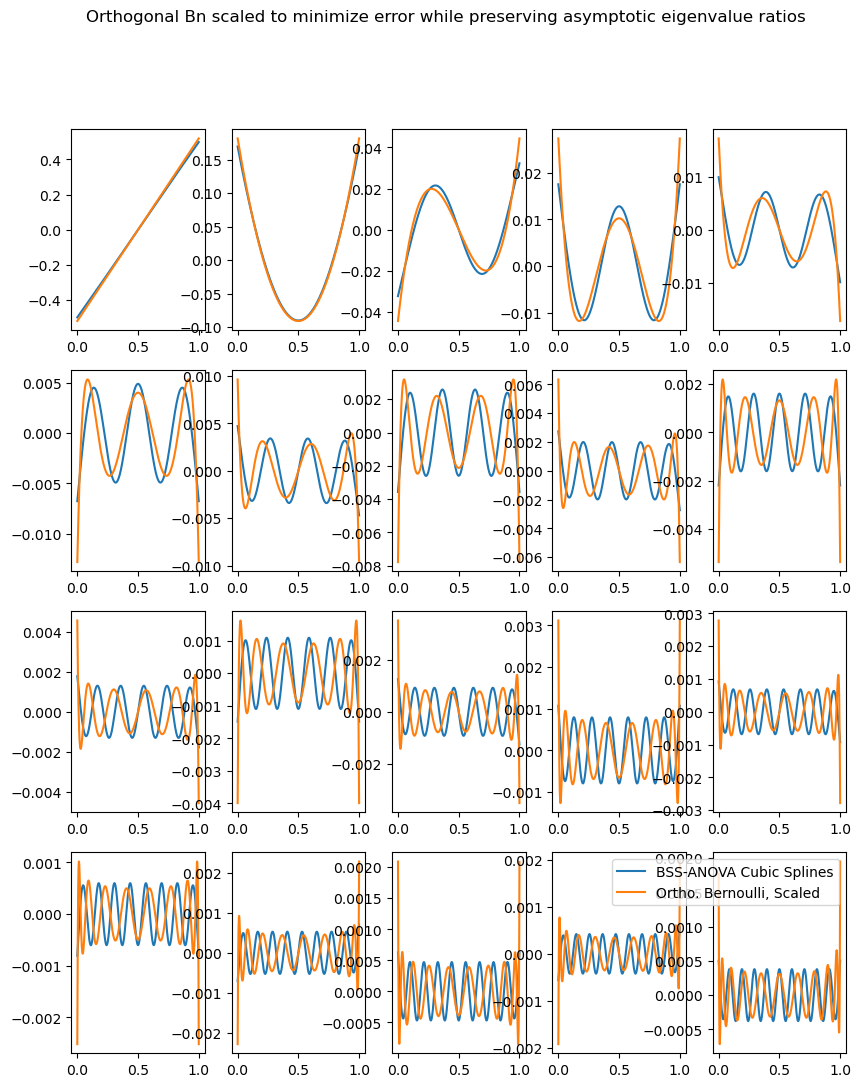

In [5]:
fig, axs = plt.subplots(4, 5, figsize=(10, 12))
j = 0
for row in range(4):
    for col in range(5):
        axs[row, col].plot(x, y_bss[j])  # BSS-ANOVA
        axs[row, col].plot(x, sum(b_in[j][k] * x ** k for k in range(len(b_in[j]))))  # scaled Bn
        j += 1

fig.suptitle('Orthogonal Bn scaled to minimize error while preserving asymptotic eigenvalue ratios')
plt.legend(['BSS-ANOVA Cubic Splines', 'Ortho. Bernoulli, Scaled'])

Save the coefficients of the new basis functions, $\phi_{i, \mathcal{B}}$.

In [10]:
b_in_mtx = np.zeros([len(b_in), len(b_in) + 1])
for i in range(len(b_in)):
    b_in_mtx[i, :(i + 2)] = b_in[i]

np.savetxt('orthogonal_Bn_scaled.txt', b_in_mtx)

The coefficients are as follows.

|  | $x^0$ | $x^1$ | $x^2$ | $x^3$ | $\dots$ | $x^{20}$ |
|---|---|---|---|---|---|---|
| $\phi_{1, \mathcal{B}}$ | -5.196152752436606903e-01 | 1.039230550487318272e+00 | 0 | 0 | $\dots$ | 0 |
| $\phi_{2, \mathcal{B}}$ | 1.818751475735329304e-01 | -1.091250885441194418e+00 | 1.091250885441194418e+00 | 0 | $\dots$ | 0 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\ddots$ | $\vdots$ |
| $\phi_{20, \mathcal{B}}$ | 1.772044853221473471e-03 | -7.442588383530196472e-01 | 7.777504860789051122e+01 | -3.577652235962967552e+03| $\dots$ | 2.442702319299265146e+08 |

*orthogonal_Bn_scaled.txt* was copied to "/src/FoKL/kernels", and is read by *getKernels*.